In [1]:
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score
import glob
import dask.dataframe as dd
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster

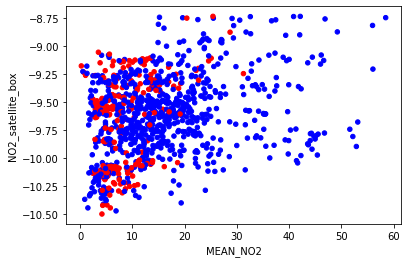

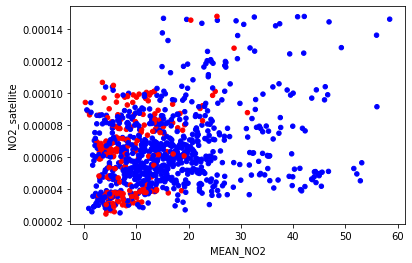

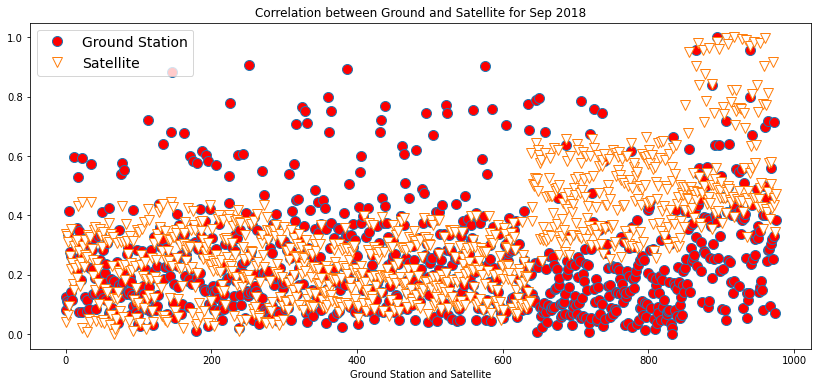

In [2]:
#Calculation for combined 2018

df_combined_2018= pd.read_csv('combined_NO2_1km.csv')
df=df_combined_2018

MEAN_NO2_combined=df['MEAN_NO2'].values
NO2_satellite_combined=df['NO2_satellite'].values

df['NO2_satellite_box'],_ = stats.boxcox(df['NO2_satellite'])
colors = np.where(df.COUNT > 300, 'r', 'b')
df.plot.scatter(x='MEAN_NO2',y='NO2_satellite_box', c=colors)
df.plot.scatter(x='MEAN_NO2',y='NO2_satellite', c=colors)

scaler=MinMaxScaler()
MEAN_NO2=df['MEAN_NO2'].values
MEAN_NO2=MEAN_NO2.reshape(-1,1)
MEAN_NO2=scaler.fit_transform(MEAN_NO2)


NO2_satellite=df['NO2_satellite'].values
NO2_satellite=NO2_satellite.reshape(-1,1)
NO2_satellite=scaler.fit_transform(NO2_satellite)



df['MEAN_NO2_T']= pd.DataFrame(MEAN_NO2)
df['NO2_satellite_T']= pd.DataFrame(NO2_satellite)

#df.corr()['MEAN_NO2_T'].sort_values().plot(kind='bar')

fig = plt.figure(figsize=(14,6))
plt.plot(MEAN_NO2,marker="o", ms = 10, mfc = 'r', linestyle='None',label='Ground Station')
plt.plot(NO2_satellite,marker="v", ms = 10,linestyle='None', mfc = 'w',label='Satellite')
plt.title('Correlation between Ground and Satellite for combined 2018')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Ground Station and Satellite')



corr=df.corr()['MEAN_NO2'].sort_values()

corr=list(corr)

grnd_corr_combined=corr[2]



In [3]:
df= df.drop(df.tail(16).index)

In [4]:
dtale.show(df)

In [5]:
#Reading CAMs Data for May 2018
no2_combined = xr.open_dataset("CAMS_2018_combined_12.00_Surface.nc", engine="netcdf4")
no2_combined

<xarray.Dataset>
Dimensions:    (latitude: 1441, longitude: 2880, time: 30)
Coordinates:
  * longitude  (longitude) float32 0.0 0.125 0.25 0.375 ... 359.6 359.8 359.9
  * latitude   (latitude) float32 90.0 89.88 89.75 89.62 ... -89.75 -89.88 -90.0
  * time       (time) datetime64[ns] 2018-09-01T12:00:00 ... 2018-09-30T12:00:00
Data variables:
    tcno2      (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-22 19:57:52 GMT by grib_to_netcdf-2.21.0: grib_to_n...

In [6]:
#Extracting Each Variables 
tno2_combined=no2_combined.tcno2
u10_combined=no2_combined.u10
v10_combined=no2_combined.v10
t2m_combined=no2_combined.t2m
lsp_combined=no2_combined.lsp

In [7]:
t2m_combined

<xarray.DataArray 't2m' (time: 30, latitude: 1441, longitude: 2880)>
[124502400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.125 0.25 0.375 ... 359.6 359.8 359.9
  * latitude   (latitude) float32 90.0 89.88 89.75 89.62 ... -89.75 -89.88 -90.0
  * time       (time) datetime64[ns] 2018-09-01T12:00:00 ... 2018-09-30T12:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [8]:
#Finding the index for particular Lat and Lon
lat_ind= np.where(tno2_combined.latitude.data==38) 
lon_ind= np.where(tno2_combined.longitude.data==58)
lat_ind=int(lat_ind[0])
lon_ind=int(lon_ind[0])
print(no2_combined.longitude.data[lon_ind:lon_ind+14])
print(tno2_combined.latitude.data[lat_ind:lat_ind+14])

[58.    58.125 58.25  58.375 58.5   58.625 58.75  58.875 59.    59.125
 59.25  59.375 59.5   59.625]
[38.    37.875 37.75  37.625 37.5   37.375 37.25  37.125 37.    36.875
 36.75  36.625 36.5   36.375]


In [9]:
#Extracting No2 for the bay area for The Month of combined
cams_no2=[]
for i in range(30):
   cams_no2_1=list(tno2_combined.data[i,lon_ind:lon_ind+16,58])
   cams_no2_2=list(tno2_combined.data[i,37,lat_ind:lat_ind+16])
   cams_no2=cams_no2+cams_no2_1+cams_no2_2
   #print(cams_no2)

In [10]:
#Extracting u10 (10 metre U wind component) for the bay area for The Month of combined
cams_u10=[]
for i in range(30):
   cams_u10_1=list(u10_combined.data[i,lon_ind:lon_ind+16,58])
   cams_u10_2=list(u10_combined.data[i,37,lat_ind:lat_ind+16])
   cams_u10=cams_u10+cams_u10_1+cams_u10_2

In [11]:
#Extracting v10 (10 metre V wind component) for the bay area for The Month of combined
cams_v10=[]
for i in range(30):
   cams_v10_1=list(v10_combined.data[i,lon_ind:lon_ind+16,58])
   cams_v10_2=list(v10_combined.data[i,37,lat_ind:lat_ind+16])
   cams_v10=cams_v10+cams_v10_1+cams_v10_2


In [12]:
#Extracting t2m (2 metre temperature) for the bay area for The Month of combined
cams_t2m=[]
for i in range(30):
   cams_t2m_1=list(t2m_combined.data[i,lon_ind:lon_ind+16,58])
   cams_t2m_2=list(t2m_combined.data[i,37,lat_ind:lat_ind+16])
   cams_t2m=cams_t2m+cams_t2m_1+cams_t2m_2


In [13]:
#Extracting lsp (Large-scale precipitation) for the bay area for The Month of combined
cams_lsp=[]
for i in range(30):
   cams_lsp_1=list(lsp_combined.data[i,lon_ind:lon_ind+16,58])
   cams_lsp_2=list(lsp_combined.data[i,37,lat_ind:lat_ind+16])
   cams_lsp=cams_lsp+cams_lsp_1+cams_lsp_2

In [14]:
df['cams_no2']=cams_no2
df['cams_u10']=cams_u10
df['cams_v10']=cams_v10
#df['cams_t2m']=cams_t2m
#df['cams_lsp']=cams_lsp

In [15]:
df=df.drop(['COUNT','MEAN_NO2_T','NO2_satellite_T','NO2_satellite_box'],axis=1)

In [16]:
dtale.show(df)

In [17]:
X=df.drop('MEAN_NO2',axis=1).values
y=df['MEAN_NO2'].values

In [18]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [19]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,0.117924,"{'C': 10, 'kernel': 'linear'}"
1,random_forest,0.467233,{'n_estimators': 15}


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [21]:
model = SVR(kernel='linear', C=10, gamma='auto', degree=2, epsilon=.1,
               coef0=1)
model.fit(X_train,y_train)

SVR(C=10, coef0=1, degree=2, gamma='auto', kernel='linear')

In [22]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

Mean Squared Error = 106.462878869928


In [23]:
RMSE=mean_squared_error(y_test,prediction, squared=False)
print("Root Mean Square Error =",RMSE)

Root Mean Square Error = 10.318085038897868


Text(0, 0.5, 'No2 (mol/m2)')

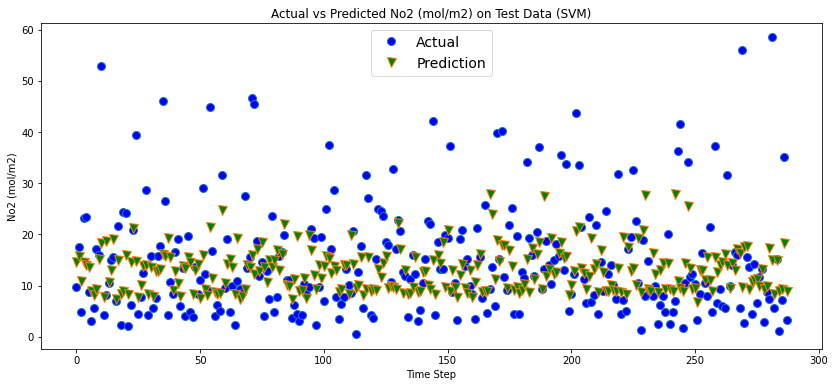

In [24]:
fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Test Data (SVM)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')

In [25]:
all_prediction=model.predict(X)

In [26]:
Mean_no2=df['MEAN_NO2']

Text(0, 0.5, 'No2 (mol/m2)')

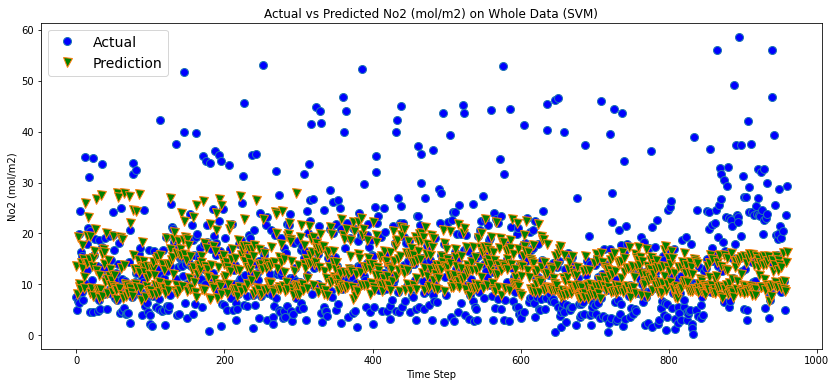

In [27]:
fig = plt.figure(figsize=(14,6))
plt.plot(Mean_no2,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Whole Data (SVM)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


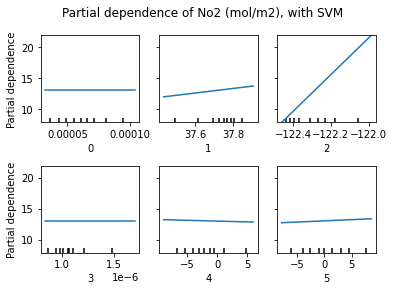

In [28]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5])

display.figure_.suptitle('Partial dependence of No2 (mol/m2), with SVM')
display.figure_.subplots_adjust(hspace=0.5)

[58.    58.125 58.25  58.375 58.5   58.625 58.75  58.875 59.    59.125
 59.25  59.375 59.5   59.625]
[38.    37.875 37.75  37.625 37.5   37.375 37.25  37.125 37.    36.875
 36.75  36.625 36.5   36.375]
Mean Squared Error = 37.56060390807059
Root Mean Square Error = 6.128670647707429


Text(0, 0.5, 'No2 (mol/m2)')

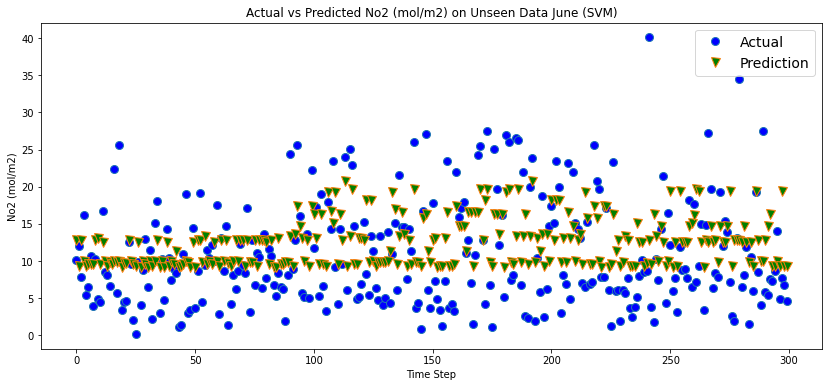

In [102]:
#Calculation for Unseen data
df_june_2018= pd.read_csv('2018 June Grnd.csv')


#Reading CAMs Data for June 2018
no2_june = xr.open_dataset("CAMS_2018_June_12.00_Surface.nc", engine="netcdf4")
no2_june



#Extracting Each Variables 
tno2_june=no2_june.tcno2
u10_june=no2_june.u10
v10_june=no2_june.v10
t2m_june=no2_june.t2m
lsp_june=no2_june.lsp



#Finding the index for particular Lat and Lon
lat_ind= np.where(tno2_june.latitude.data==38) 
lon_ind= np.where(tno2_june.longitude.data==58)
lat_ind=int(lat_ind[0])
lon_ind=int(lon_ind[0])
print(no2_june.longitude.data[lon_ind:lon_ind+14])
print(tno2_june.latitude.data[lat_ind:lat_ind+14])

#Extracting No2 for the bay area for The Month of june
cams_no2=[]
for i in range(30):
   cams_no2_1=list(tno2_june.data[i,lon_ind:lon_ind+5,58])
   cams_no2_2=list(tno2_june.data[i,37,lat_ind:lat_ind+5])
   cams_no2=cams_no2+cams_no2_1+cams_no2_2
   #print(cams_no2)

#Extracting u10 (10 metre U wind component) for the bay area for The Month of june
cams_u10=[]
for i in range(30):
   cams_u10_1=list(u10_june.data[i,lon_ind:lon_ind+5,58])
   cams_u10_2=list(u10_june.data[i,37,lat_ind:lat_ind+5])
   cams_u10=cams_u10+cams_u10_1+cams_u10_2

#Extracting v10 (10 metre V wind component) for the bay area for The Month of june
cams_v10=[]
for i in range(30):
   cams_v10_1=list(v10_june.data[i,lon_ind:lon_ind+5,58])
   cams_v10_2=list(v10_june.data[i,37,lat_ind:lat_ind+5])
   cams_v10=cams_v10+cams_v10_1+cams_v10_2

#Extracting t2m (2 metre temperature) for the bay area for The Month of june
cams_t2m=[]
for i in range(30):
   cams_t2m_1=list(t2m_june.data[i,lon_ind:lon_ind+5,58])
   cams_t2m_2=list(t2m_june.data[i,37,lat_ind:lat_ind+5])
   cams_t2m=cams_t2m+cams_t2m_1+cams_t2m_2

#Extracting lsp (Large-scale precipitation) for the bay area for The Month of june
cams_lsp=[]
for i in range(30):
   cams_lsp_1=list(lsp_june.data[i,lon_ind:lon_ind+5,58])
   cams_lsp_2=list(lsp_june.data[i,37,lat_ind:lat_ind+5])
   cams_lsp=cams_lsp+cams_lsp_1+cams_lsp_2


df_june_2018['cams_no2']=cams_no2
df_june_2018['cams_u10']=cams_u10
df_june_2018['cams_v10']=cams_v10
#df_june_2018['cams_t2m']=cams_t2m
#df_june_2018['cams_lsp']=cams_lsp


df_june_2018=df_june_2018.drop(['COUNT'],axis=1)


X_june=df_june_2018.drop('MEAN_NO2',axis=1).values
y_june=df_june_2018['MEAN_NO2'].values


prediction=model.predict(X_june)
MSE=mean_squared_error(y_june,prediction)
print("Mean Squared Error =",MSE)



RMSE=mean_squared_error(y_june,prediction, squared=False)
print("Root Mean Square Error =",RMSE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_june,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Unseen Data June (SVM)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


In [103]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15)

In [104]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

Mean Squared Error = 59.71594475135377


In [105]:
RMSE=mean_squared_error(y_test,prediction, squared=False)
print("Root Mean Square Error =",RMSE)

Root Mean Square Error = 7.727609251984327


Text(0, 0.5, 'No2 (mol/m2)')

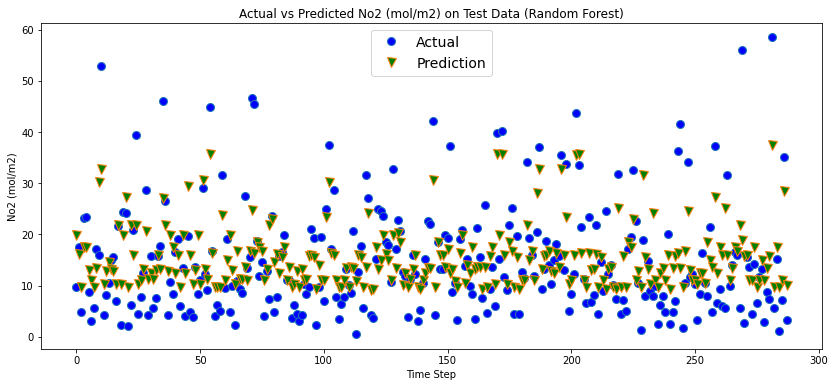

In [106]:

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


In [107]:
all_prediction=model.predict(X)

Text(0, 0.5, 'No2 (mol/m2)')

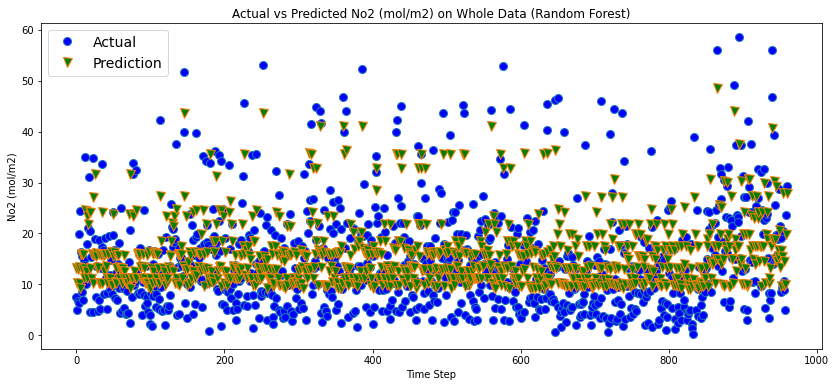

In [108]:
fig = plt.figure(figsize=(14,6))
plt.plot(Mean_no2,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


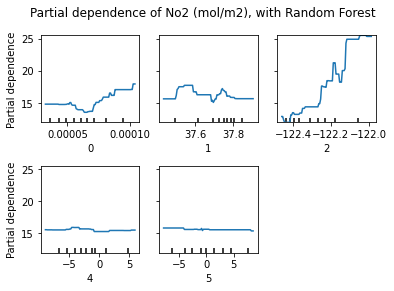

In [109]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,4,5])

display.figure_.suptitle('Partial dependence of No2 (mol/m2), with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

[58.    58.125 58.25  58.375 58.5   58.625 58.75  58.875 59.    59.125
 59.25  59.375 59.5   59.625]
[38.    37.875 37.75  37.625 37.5   37.375 37.25  37.125 37.    36.875
 36.75  36.625 36.5   36.375]
Mean Squared Error = 38.957062130238796
Root Mean Square Error = 6.241559270746277


Text(0, 0.5, 'No2 (mol/m2)')

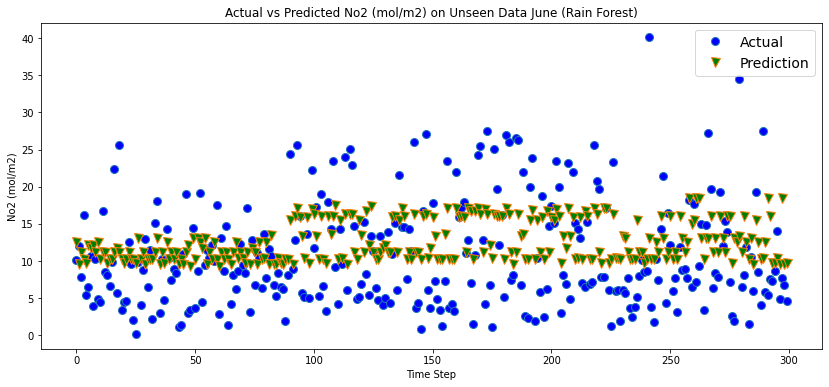

In [110]:
#Calculation for Unseen data
df_june_2018= pd.read_csv('2018 June Grnd.csv')


#Reading CAMs Data for June 2018
no2_june = xr.open_dataset("CAMS_2018_June_12.00_Surface.nc", engine="netcdf4")
no2_june


# In[106]:


#Extracting Each Variables 
tno2_june=no2_june.tcno2
u10_june=no2_june.u10
v10_june=no2_june.v10
t2m_june=no2_june.t2m
lsp_june=no2_june.lsp


# In[107]:


u10_june.data.shape


# In[108]:


#Finding the index for particular Lat and Lon
lat_ind= np.where(tno2_june.latitude.data==38) 
lon_ind= np.where(tno2_june.longitude.data==58)
lat_ind=int(lat_ind[0])
lon_ind=int(lon_ind[0])
print(no2_june.longitude.data[lon_ind:lon_ind+14])
print(tno2_june.latitude.data[lat_ind:lat_ind+14])

#Extracting No2 for the bay area for The Month of june
cams_no2=[]
for i in range(30):
   cams_no2_1=list(tno2_june.data[i,lon_ind:lon_ind+5,58])
   cams_no2_2=list(tno2_june.data[i,37,lat_ind:lat_ind+5])
   cams_no2=cams_no2+cams_no2_1+cams_no2_2
   #print(cams_no2)

#Extracting u10 (10 metre U wind component) for the bay area for The Month of june
cams_u10=[]
for i in range(30):
   cams_u10_1=list(u10_june.data[i,lon_ind:lon_ind+5,58])
   cams_u10_2=list(u10_june.data[i,37,lat_ind:lat_ind+5])
   cams_u10=cams_u10+cams_u10_1+cams_u10_2

#Extracting v10 (10 metre V wind component) for the bay area for The Month of june
cams_v10=[]
for i in range(30):
   cams_v10_1=list(v10_june.data[i,lon_ind:lon_ind+5,58])
   cams_v10_2=list(v10_june.data[i,37,lat_ind:lat_ind+5])
   cams_v10=cams_v10+cams_v10_1+cams_v10_2

#Extracting t2m (2 metre temperature) for the bay area for The Month of june
cams_t2m=[]
for i in range(30):
   cams_t2m_1=list(t2m_june.data[i,lon_ind:lon_ind+5,58])
   cams_t2m_2=list(t2m_june.data[i,37,lat_ind:lat_ind+5])
   cams_t2m=cams_t2m+cams_t2m_1+cams_t2m_2

#Extracting lsp (Large-scale precipitation) for the bay area for The Month of june
cams_lsp=[]
for i in range(30):
   cams_lsp_1=list(lsp_june.data[i,lon_ind:lon_ind+5,58])
   cams_lsp_2=list(lsp_june.data[i,37,lat_ind:lat_ind+5])
   cams_lsp=cams_lsp+cams_lsp_1+cams_lsp_2


df_june_2018['cams_no2']=cams_no2
df_june_2018['cams_u10']=cams_u10
df_june_2018['cams_v10']=cams_v10
#df_june_2018['cams_t2m']=cams_t2m
#df_june_2018['cams_t2m']=cams_lsp


df_june_2018=df_june_2018.drop(['COUNT'],axis=1)


X_june=df_june_2018.drop('MEAN_NO2',axis=1).values
y_june=df_june_2018['MEAN_NO2'].values


prediction=model.predict(X_june)
MSE=mean_squared_error(y_june,prediction)
print("Mean Squared Error =",MSE)


# In[126]:


RMSE=mean_squared_error(y_june,prediction, squared=False)
print("Root Mean Square Error =",RMSE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_june,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Unseen Data June (Rain Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


In [111]:
import dask.dataframe as dd
import hvplot.dask 
import datashader as ds
import colorcet
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, viridis
from functools import partial
from IPython.core.display import HTML, display, Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
#import rioxarray as rio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
#import geopandas as gpd
import earthpy as et

In [112]:
#Calculation for extreme values in spatial map
df_2019_1= pd.read_csv('data_2019_NO2.csv')
df_2019= pd.read_csv('combined_NO2_1km.csv')

In [113]:
dtale.show(df_2019)

In [114]:
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

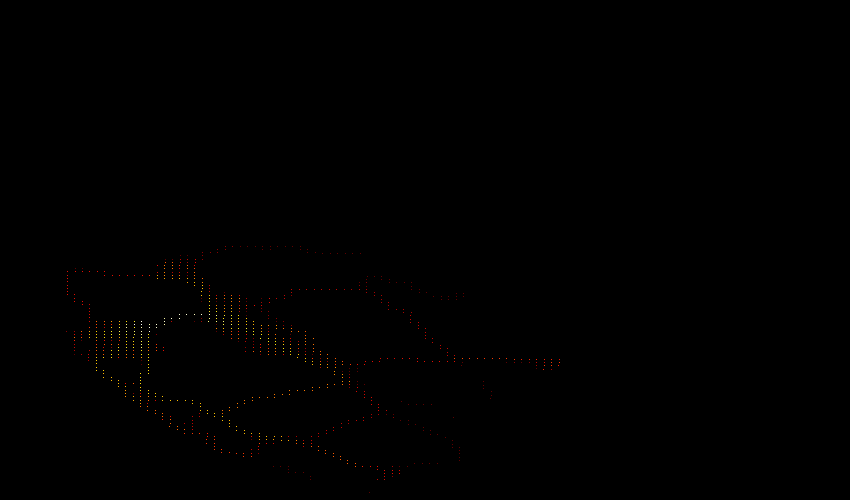

In [115]:
cvs = ds.Canvas(plot_width=850, plot_height=500)
agg = cvs.points(df_2019, 'Longitude', 'Latitude')
export(ds.tf.shade(agg, cmap = colorcet.fire, how='log'),"census_gray_log")

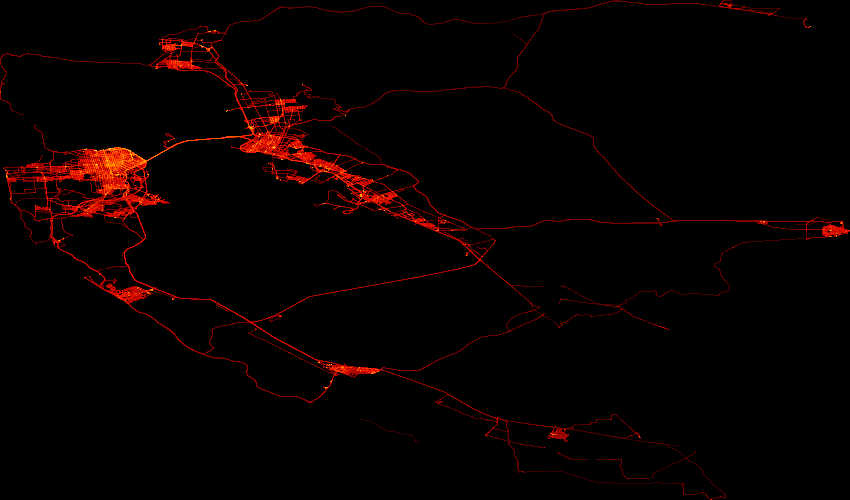

In [116]:
cvs = ds.Canvas(plot_width=850, plot_height=500)
agg = cvs.points(df_2019_1, 'Longitude', 'Latitude')
export(ds.tf.shade(agg, cmap = colorcet.fire, how='log'),"census_gray_log")

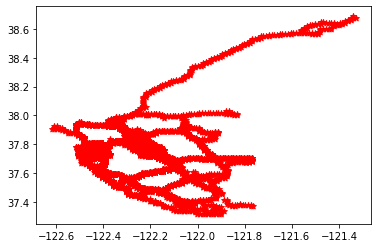

In [117]:
plt.scatter(df_2019['Longitude'],df_2019['Latitude'],marker="*", linestyle='None', color= 'r')

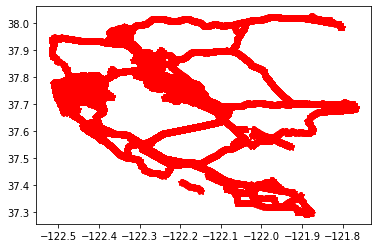

In [118]:
plt.scatter(df_2019_1['Longitude'],df_2019_1['Latitude'],marker="*", linestyle='None', color= 'r')

In [119]:
dtale.show(df)

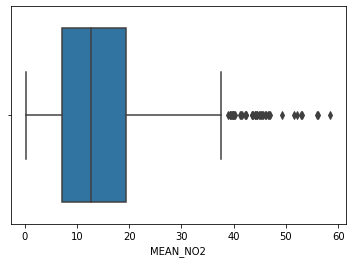

In [139]:
sns.boxplot(df['MEAN_NO2'])

In [140]:
# Position of the Outlier
print(np.where(df['MEAN_NO2']>38))

(array([113, 145, 146, 162, 226, 252, 317, 324, 329, 331, 360, 361, 364,
       386, 432, 433, 439, 495, 504, 522, 524, 560, 576, 585, 604, 635,
       636, 646, 650, 658, 708, 720, 726, 737, 834, 865, 888, 895, 907,
       939, 940, 942]),)


In [141]:
out_index=np.where(df['MEAN_NO2']>38)

In [142]:
out_index[0]

array([113, 145, 146, 162, 226, 252, 317, 324, 329, 331, 360, 361, 364,
       386, 432, 433, 439, 495, 504, 522, 524, 560, 576, 585, 604, 635,
       636, 646, 650, 658, 708, 720, 726, 737, 834, 865, 888, 895, 907,
       939, 940, 942])

In [143]:
df_solid= df.drop(out_index[0])

In [144]:
in_index=np.where(df['MEAN_NO2']<38)

In [145]:
df_out= df.drop(in_index[0])

In [146]:
dtale.show(df_out)

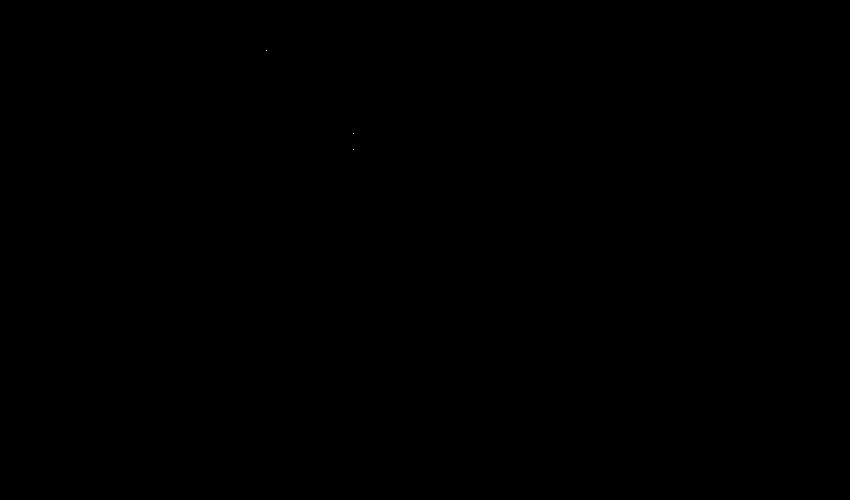

In [147]:
cvs = ds.Canvas(plot_width=850, plot_height=500)
agg = cvs.points(df_out, 'Longitude', 'Latitude')
export(ds.tf.shade(agg, cmap = colorcet.fire, how='log'),"census_gray_log")

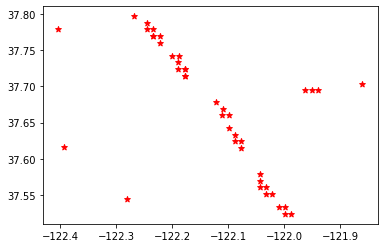

In [148]:
plt.scatter(df_out['Longitude'],df_out['Latitude'],marker="*", linestyle='None', color= 'r')

In [149]:
No2_heatmap=df_out[['Latitude','Longitude','MEAN_NO2']]

In [150]:
No2_heatmap=No2_heatmap.reset_index(drop=True)

In [151]:
dtale.show(No2_heatmap)

In [158]:
def generateBaseMap(default_location=[37.8715, -122.2730], default_zoom_start=12):
    base_map = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return base_map

In [159]:
basemap=generateBaseMap()
basemap

In [154]:
HeatMap(df[['Latitude','Longitude','MEAN_NO2']],zoom=20,radius=15).add_to(basemap)
basemap

In [155]:
# Plugin: FastMarkerCluster
FastMarkerCluster(df[['Latitude','Longitude','MEAN_NO2']].values.tolist()).add_to(basemap)
basemap

In [160]:
HeatMap(No2_heatmap[['Latitude','Longitude','MEAN_NO2']],zoom=20,radius=15).add_to(basemap)
basemap

In [161]:
# Plugin: FastMarkerCluster
FastMarkerCluster(No2_heatmap[['Latitude','Longitude','MEAN_NO2']].values.tolist()).add_to(basemap)
basemap